# Robotic Investment for Lending Club Project

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime
from scipy.stats import skew, boxcox
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn import metrics, preprocessing, cross_validation
import xgboost as xgb

## Data Initiation

Import data, which is downloaded from LendingClub website.

In [209]:
loan2014 = pd.read_csv('FinTech_Loan_Data_2014/LoanStats3c2014.csv',error_bad_lines=False,encoding='latin-1')

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [210]:
loan2015 = pd.read_csv('FinTech_Loan_Data_2015/LoanStats3d.csv',error_bad_lines=False,encoding='latin-1')

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [211]:
print('Data shape for 2014: ',loan2014.shape)
print('Data shape for 2015: ',loan2015.shape)
# Combined 2 years data
fulldata = pd.concat([loan2014,loan2015])
print('Data shape for fulldata: ',fulldata.shape)

Data shape for 2014:  (235629, 145)
Data shape for 2015:  (421095, 145)
Data shape for fulldata:  (656724, 145)


Since we only care about data with the loan term 36 month and with a certain loan status(Fully paid and charged off), we made some adjustment on data first.

## Data preparation

### NaN values
Through checking the data, we can see there are too many NAN values in df for some features and we should delete them. 

In [212]:
# Detect how many value are missing in df
def missing_value_detector(dataframe):
    missing_df = dataframe.isnull().sum().reset_index()
    missing_df.columns = ['feature','numMissing']
    missing_df['missingPercent'] = round(missing_df['numMissing']/len(dataframe),2)
    missing_df = missing_df.loc[missing_df['missingPercent']>0]
    missing_df = missing_df.sort_values(by='missingPercent')
    
    return missing_df

In [213]:
# Check the missing value percentage in the dataframe
missing_value_detector(fulldata)

,feature,numMissing,missingPercent
85,mths_since_recent_bc,6044,0.01
77,bc_util,6838,0.01
76,bc_open_to_buy,6408,0.01
104,percent_bc_gt_75,6796,0.01
80,mo_sin_old_il_acct,19425,0.03
99,num_tl_120dpd_2m,27090,0.04
10,emp_title,37110,0.06
87,mths_since_recent_inq,66291,0.10
28,mths_since_last_delinq,319843,0.49
88,mths_since_recent_revol_delinq,420221,0.64


In [214]:
# Select and delete the features that contains more than 40% of missing values
missingToomuch = list(missing_value_detector(fulldata).loc[missing_value_detector(fulldata)['missingPercent']>0.4]['feature'])
fulldata.drop(fulldata[missingToomuch],axis=1,inplace = True)

In [215]:
print('Fulldata shape is: ',fulldata.shape)
missing_value_detector(fulldata)

Fulldata shape is:  (656724, 87)


,feature,numMissing,missingPercent
51,bc_open_to_buy,6408,0.01
52,bc_util,6838,0.01
60,mths_since_recent_bc,6044,0.01
77,percent_bc_gt_75,6796,0.01
55,mo_sin_old_il_acct,19425,0.03
72,num_tl_120dpd_2m,27090,0.04
8,emp_title,37110,0.06
61,mths_since_recent_inq,66291,0.10


In [216]:
missing_value_minor = ['bc_open_to_buy', 'bc_util', 'mths_since_recent_bc',
       'percent_bc_gt_75', 'mo_sin_old_il_acct', 'num_tl_120dpd_2m',
       'mths_since_recent_inq','avg_cur_bal','revol_util','num_rev_accts','dti']

# Fill nan with median, since the missing value is small, if there are a lot. We need to check if value has skewness or other properties.
for x in missing_value_minor:
    fulldata[x].fillna(value = fulldata[x].median(),inplace=True)

### Categorical & Numerical features
Select categorical and numerical features. Noted that some cols with dtypes of int may also be categorical.

In [217]:
cat_features = list(fulldata.select_dtypes(include=['object']).columns)
# select numerical features
num_features = list(fulldata.select_dtypes(exclude=['object']).columns)


Check the categorical features' distribution, we can see several features are actually 

* numerical(term, int_rate, etc.).

* extremely unbalanced(pymnt_plan,application_type, etc.). 

* date-time features.

* include only one value and has no meaning to exist in features. 

* contained many values but duplicated values due to capitalized words.


We should reformat these features.

#### Catagorical

In [218]:
for cat in cat_features:
    print(fulldata[cat].value_counts(normalize=True))

 36 months    0.678737
 60 months    0.321263
Name: term, dtype: float64
10.99%    0.046386
9.17%     0.039152
15.61%    0.034167
7.89%     0.030917
9.99%     0.029865
12.29%    0.028239
12.69%    0.027419
8.18%     0.027121
13.99%    0.027065
13.33%    0.026751
17.57%    0.026749
11.53%    0.024637
16.99%    0.024394
12.99%    0.023336
14.65%    0.020535
11.99%    0.017557
16.55%    0.016663
17.86%    0.015908
14.99%    0.015385
12.49%    0.014776
5.32%     0.014697
7.26%     0.014370
18.25%    0.014265
13.98%    0.013485
13.35%    0.011603
6.24%     0.011372
11.67%    0.011047
14.49%    0.011029
6.89%     0.010676
19.99%    0.009362
            ...   
11.48%    0.000635
21.48%    0.000627
8.49%     0.000598
13.44%    0.000580
27.31%    0.000528
14.85%    0.000518
7.91%     0.000495
26.06%    0.000463
22.40%    0.000420
15.77%    0.000393
6.00%     0.000344
27.88%    0.000338
23.40%    0.000326
22.90%    0.000323
17.27%    0.000266
17.97%    0.000256
23.70%    0.000248
28.49%    0.000

Name: title, Length: 2071, dtype: float64
750xx    0.010583
945xx    0.010482
112xx    0.009977
606xx    0.009468
300xx    0.009275
331xx    0.008165
070xx    0.008070
770xx    0.007836
100xx    0.007812
900xx    0.007621
891xx    0.007215
330xx    0.007058
117xx    0.007001
917xx    0.006837
104xx    0.006738
852xx    0.006153
921xx    0.005993
926xx    0.005739
913xx    0.005622
925xx    0.005454
481xx    0.005432
334xx    0.005293
601xx    0.005285
600xx    0.005244
604xx    0.005234
113xx    0.005097
080xx    0.005033
853xx    0.004879
920xx    0.004766
956xx    0.004762
           ...   
663xx    0.000002
889xx    0.000002
502xx    0.000002
343xx    0.000002
507xx    0.000002
909xx    0.000002
742xx    0.000002
694xx    0.000002
938xx    0.000002
340xx    0.000002
702xx    0.000002
682xx    0.000002
093xx    0.000002
649xx    0.000002
353xx    0.000002
503xx    0.000002
892xx    0.000002
509xx    0.000002
817xx    0.000002
709xx    0.000002
399xx    0.000002
849xx    0.000002
520x

* Transfer catagorical features to numerical.

In [219]:
fulldata['term'] = fulldata['term'].apply(lambda x: int(str(x).split(' ')[1]))
fulldata['int_rate'] = fulldata['int_rate'].apply(lambda x: float(str(x).split('%')[0]))
fulldata['revol_util'] = fulldata['revol_util'].apply(lambda x: float(str(x).split('%')[0]))
fulldata['emp_title'] = fulldata['emp_title'].apply(lambda x: str(x).lower())
fulldata['emp_length'] = fulldata['emp_length'].replace({'10+ years': 10, '2 years':2, '< 1 year':0, '3 years':3, '1 year':1, '4 years':4,
                               '5 years':5, 'n/a':-999, '8 years':8, '7 years':7, '6 years':6, '9 years':9})

* Transfer datetime features to numerical.

In [220]:
# Transfer dates value to months' difference btw datetime and current time
today = datetime.datetime.now() 

def transfer_datetime(dt):
    try:
        months = round((today - datetime.datetime.strptime(str(dt), "%b-%y")).days/30, 2)
    except:
        months = 0
    return months

In [221]:
fulldata['issue_d'] = fulldata['issue_d'].apply(lambda x : transfer_datetime(x))
fulldata['earliest_cr_line'] = fulldata['earliest_cr_line'].apply(lambda x : transfer_datetime(x))
fulldata['last_pymnt_d'] = fulldata['last_pymnt_d'].apply(lambda x : transfer_datetime(x))
fulldata['last_credit_pull_d'] = fulldata['last_credit_pull_d'].apply(lambda x : transfer_datetime(x))
fulldata['zip_code'] = fulldata['zip_code'].apply(lambda x: str(str(x).split('x')[0]))

* Check extremely unbalanced features

** debt_settlement_flag:**  Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.

From the countplot of loan_status, there are no people who is both working for a debt-settlement and not been charged off, which means people working with debt-settlement company is 100% charged off.

In that case, although y only take 0.01908 of total data, it is valuable to keep it.

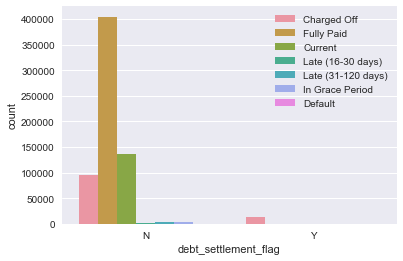

In [222]:
dsf = sns.countplot(x = 'debt_settlement_flag',hue = 'loan_status', data = fulldata)
dsf.legend_.remove()
dsf.legend(loc = 1)

**disbursement_method: **
Only have one value - cash. No need to exist.

In [223]:
fulldata.drop(['disbursement_method'],axis = 1, inplace = True)

**hardship_flag: **Flags whether or not the borrower is on a hardship plan

The hardship_flag is not a flag to charged off. We only need information to predict fully paid or charged off and will drop data in other loan status. Hence, the hardship_flag, which is related to late-payment can be droped here.

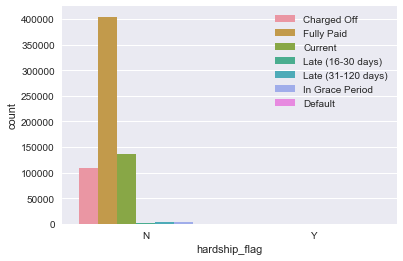

In [224]:
hf = sns.countplot(x = 'hardship_flag',hue = 'loan_status', data = fulldata)
hf.legend_.remove()
hf.legend(loc = 1)

In [225]:
fulldata[fulldata['hardship_flag'] == 'Y']['loan_status'].value_counts(normalize = True)

Late (31-120 days)    0.824561
Late (16-30 days)     0.131579
In Grace Period       0.026316
Current               0.017544
Name: loan_status, dtype: float64

In [226]:
fulldata.drop(['hardship_flag'],axis = 1, inplace = True)


**application_type:** Indicates whether the loan is an individual application or a joint application with two co-borrowers.

Appliants' type would not effect the results dramaticlly, and number of Joint App is too small compare the individuals so we can drop the feature.

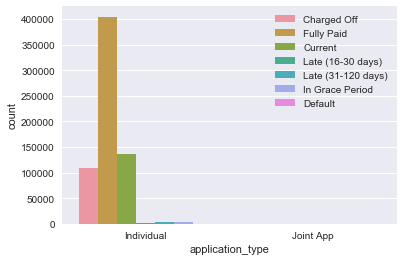

In [227]:
at = sns.countplot(x = 'application_type',hue = 'loan_status', data = fulldata)
at.legend_.remove()
at.legend(loc = 1)

In [228]:
fulldata[fulldata['application_type'] == 'Joint App']['loan_status'].value_counts(normalize = True)

Current               0.430528
Fully Paid            0.377691
Charged Off           0.166341
In Grace Period       0.015656
Late (31-120 days)    0.007828
Late (16-30 days)     0.001957
Name: loan_status, dtype: float64

In [229]:
fulldata[fulldata['application_type'] == 'Individual']['loan_status'].value_counts(normalize = True)

Fully Paid            0.616326
Current               0.206579
Charged Off           0.164678
Late (31-120 days)    0.006097
In Grace Period       0.004855
Late (16-30 days)     0.001452
Default               0.000012
Name: loan_status, dtype: float64

In [230]:
fulldata.drop(['application_type'],axis = 1, inplace = True)

**title: **The loan title provided by the borrower.

**purpose: ** A category provided by the borrower for the loan request. 

Title contains very similar contents to purpose. Drop it here.

In [231]:
fulldata.drop(['title'],axis = 1, inplace = True)

**pymnt_plan: ** Indicates if a payment plan has been put in place for the loan

Through the distribution, we notices that the payment plan is not an indicator whether the applicant will fully pay the debt or charge off. So, drop it.

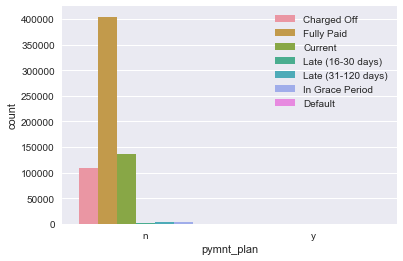

In [232]:
ppn = sns.countplot(x = 'pymnt_plan',hue = 'loan_status', data = fulldata)
ppn.legend_.remove()
ppn.legend(loc = 1)

In [233]:
fulldata[fulldata['pymnt_plan'] == 'y']['loan_status'].value_counts(normalize = True)

Late (31-120 days)    0.953488
Current               0.023256
Late (16-30 days)     0.023256
Name: loan_status, dtype: float64

In [234]:
fulldata.drop(['pymnt_plan'], axis = 1, inplace = True)

**home_ownership:**Whether the appliants own a house, have a morgate or rent one.

Any is too small to impact the model, catagorize it to rent.

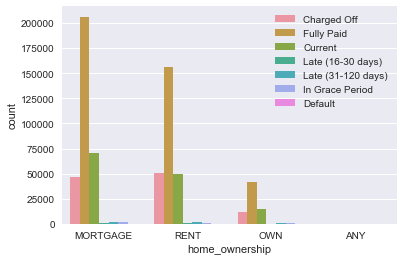

In [235]:
ho = sns.countplot(x = 'home_ownership',hue = 'loan_status', data = fulldata)
ho.legend_.remove()
ho.legend(loc = 1)

In [236]:
fulldata['home_ownership'].value_counts()

MORTGAGE    327620
RENT        260328
OWN          68773
ANY              3
Name: home_ownership, dtype: int64

In [237]:
fulldata['home_ownership'] = fulldata['home_ownership'].replace({'ANY':'RENT'})

In [238]:
# Re-initiate the catagorical and numerical features
cat_features = list(fulldata.select_dtypes(include=['object']).columns)
num_features = list(fulldata.select_dtypes(exclude=['object']).columns)

#### Numerical

In [239]:
# Calculates pearson co-efficient for all combinations for numerical features.
def HighCorrCol_detect(df, threshold, length):

    data_corr = df.corr().abs()

    # List of pairs along with correlation above threshold
    corr_list = []

    #Search for the highly correlated pairs in given features
    for i in range(0,length): 
        for j in range(i+1,length): #avoid repetition
            if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1):
#                 store correlation and columns index
                corr_list.append([data_corr.iloc[i,j],i,j]) 

    #Sort to show higher ones first            
    s_corr_list = sorted(corr_list,key=lambda x:x[0], reverse = True)

    #Print correlations and column names
    for v,i,j in s_corr_list:
        print ("%s and %s = %.2f" % (df.columns[i],df.columns[j],v))

In [240]:
HighCorrCol_detect(fulldata[num_features], 0.9, len(fulldata[num_features].columns))

out_prncp and out_prncp_inv = 1.00
total_pymnt and total_pymnt_inv = 1.00
loan_amnt and funded_amnt_inv = 1.00
funded_amnt and funded_amnt_inv = 1.00
open_acc and num_sats = 1.00
num_actv_rev_tl and num_rev_tl_bal_gt_0 = 0.98
recoveries and collection_recovery_fee = 0.98
tot_cur_bal and tot_hi_cred_lim = 0.98
total_pymnt_inv and total_rec_prncp = 0.95
total_pymnt and total_rec_prncp = 0.95
loan_amnt and installment = 0.94
funded_amnt and installment = 0.94
funded_amnt_inv and installment = 0.94


In [241]:
corr = fulldata[num_features].corr()

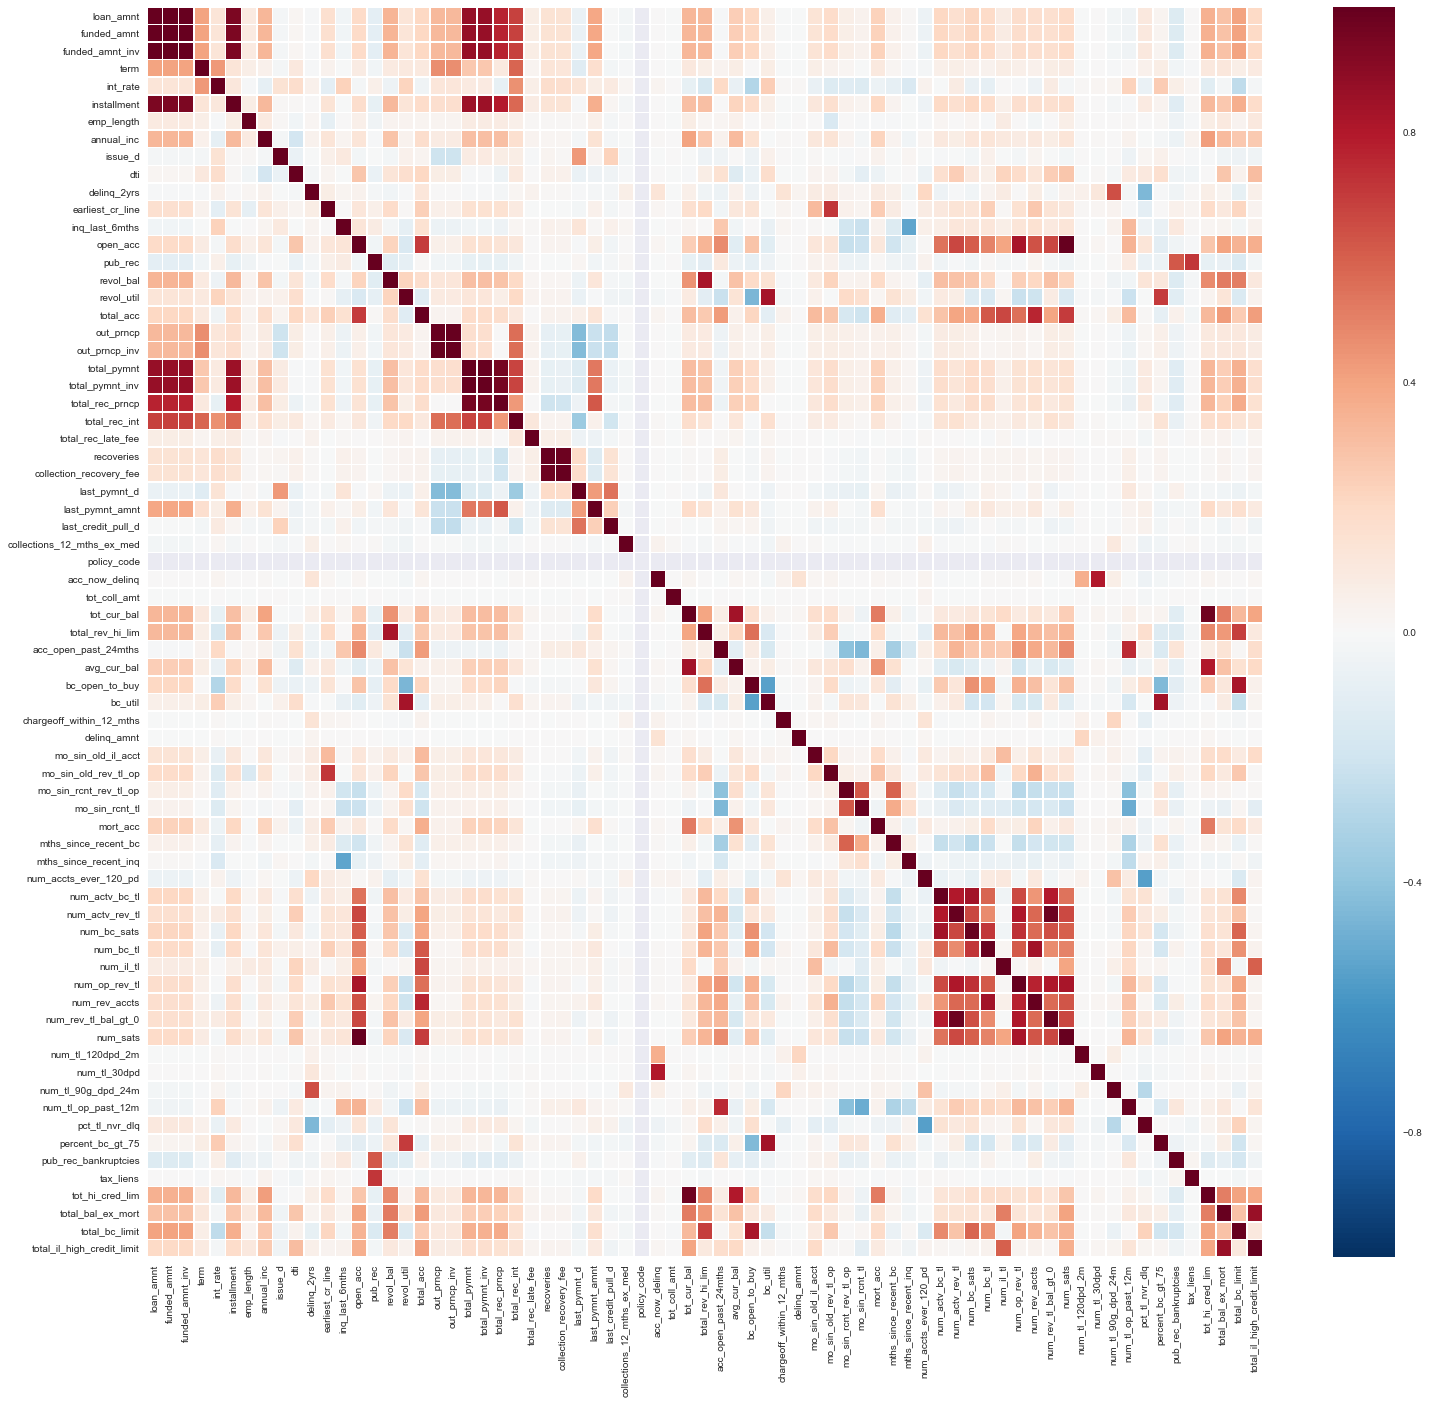

In [242]:
# Check
fig, ax = plt.subplots(figsize=(25,23))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,linewidths=0.5, ax=ax)

In [243]:
# Drop the high related features
def HighCorrCol_drop(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#   return a list of drop col
    return [column for column in upper.columns if any(upper[column] > threshold)]

In [244]:
# drop high correlated numerical features
dropcol = HighCorrCol_drop(fulldata[num_features], 0.9)
dropcol

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'collection_recovery_fee',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'tot_hi_cred_lim']

In [245]:
# Drop the features with correlation > 0.9
fulldata.drop(dropcol,axis = 1, inplace = True)

In [246]:
num_features = [a for a in num_features if a not in dropcol]

Before processing EDA, we select the needed data. 

Use 36 months as the term;

Fully paid(1), charged off(0) and default(0) as the label

In [247]:
fulldata36 = fulldata[fulldata['term'] == 36]
fulldata36 = fulldata36[(fulldata36['loan_status'] == 'Fully Paid' )| (fulldata36['loan_status'] == 'Charged Off')| (fulldata36['loan_status'] == 'Default')]
fulldata36['loan_status'] = fulldata36['loan_status'].replace({'Fully Paid': 0, 'Charged Off':1, 'Default':1})
fulldata36.drop('term',axis = 1, inplace = True)

In [248]:
fulldata36.shape

(384437, 71)

## Exploratory Data Analysis

In [249]:
fulldata36.describe()

,loan_amnt,int_rate,emp_length,annual_inc,issue_d,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,384437.000000,384437.000000,384437.000000,3.844370e+05,384437.000000,384437.000000,384435.000000,384437.000000,384437.000000,384437.000000,...,384437.000000,384437.000000,384437.000000,384437.000000,384437.000000,384437.000000,384437.000000,3.844370e+05,384437.000000,3.844370e+05
mean,12702.581372,11.871044,-56.450121,7.349827e+04,43.441278,0.160448,18.048794,0.347760,239.662811,0.665409,...,0.003751,0.099996,2.145106,93.803849,46.911021,0.147967,0.062999,4.697164e+04,19964.411555,3.940681e+04
std,7949.029793,3.822466,242.427355,6.829160e+04,6.694991,0.367021,8.378600,0.927284,100.686800,0.955166,...,0.065485,0.533980,1.777984,8.946431,35.609497,0.399842,0.455255,4.672218e+04,20964.715769,4.188653e+04
min,1000.000000,5.320000,-999.000000,0.000000e+00,32.670000,0.000000,0.000000,0.000000,-612.630000,0.000000,...,0.000000,0.000000,0.000000,7.700000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,6875.000000,8.390000,2.000000,4.350000e+04,37.770000,0.000000,11.710000,0.000000,178.770000,0.000000,...,0.000000,0.000000,1.000000,90.900000,16.700000,0.000000,0.000000,1.928200e+04,6700.000000,1.300000e+04
50%,10000.000000,11.990000,5.000000,6.100000e+04,42.770000,0.000000,17.490000,0.000000,224.430000,0.000000,...,0.000000,0.000000,2.000000,97.300000,50.000000,0.000000,0.000000,3.479600e+04,13300.000000,2.932300e+04
75%,16800.000000,14.160000,10.000000,8.900000e+04,48.900000,0.000000,23.960000,0.000000,289.330000,1.000000,...,0.000000,0.000000,3.000000,100.000000,75.000000,0.000000,0.000000,5.886200e+04,25700.000000,5.274300e+04
max,35000.000000,28.990000,10.000000,8.900060e+06,55.970000,1.000000,137.400000,30.000000,603.830000,6.000000,...,4.000000,30.000000,30.000000,100.000000,100.000000,12.000000,85.000000,2.921551e+06,760000.000000,2.101913e+06


In [250]:
cat_features_36 = list(fulldata36.select_dtypes(include=['object']).columns)
num_features_36 = list(fulldata36.select_dtypes(exclude=['object']).columns)

### Feature encoding

For catagorical features, we need to transfer them to number using label encoding or one-hot encoding.

In [251]:
for x in cat_features_36:
    print(fulldata36[x].value_counts())

B    123090
C    106001
A     88780
D     47876
E     15158
F      3143
G       389
Name: grade, dtype: int64
B5    26195
A5    26026
B3    25452
C1    24994
B4    24986
C2    24024
B2    23923
B1    22534
C3    21568
A4    20734
C4    18690
C5    16725
A3    14149
A2    14080
A1    13791
D1    13487
D2    10921
D3     9574
D4     7623
D5     6271
E1     4956
E2     3714
E3     2840
E4     1954
E5     1694
F1     1133
F3      689
F2      662
F4      400
F5      259
G1      171
G2      117
G3       61
G4       33
G5        7
Name: sub_grade, dtype: int64
nan                                        24867
teacher                                     8912
manager                                     8110
owner                                       5106
registered nurse                            4242
supervisor                                  3681
driver                                      3591
sales                                       3477
rn                                          3197

#### High cardinality feature encoding

we can see there is high cardinality features 'emp_title', and 'zip_code' in numerical features. Label encoding will make the model explain those features in ordinal relationship, which is incorrect. One-hot encoding will  expand too much data to process, expecially emp_title, which contains 92830 different values.

We can use frequency encoding to process those features.


In [252]:
fulldata36['emp_title'].nunique(),fulldata36['zip_code'].nunique()

(92830, 906)

In [253]:
zipcode_freq = fulldata36.groupby('zip_code').size().reset_index()
zipcode_freq.columns = ['zip_code', 'zipcode_freq']
emptitle_freq = fulldata36.groupby('emp_title').size().reset_index()
emptitle_freq.columns = ['emp_title', 'emptitle_freq']

In [254]:
fulldata36 = pd.merge(fulldata36, zipcode_freq, how = 'left', on = 'zip_code')
fulldata36 = pd.merge(fulldata36, emptitle_freq, how = 'left', on = 'emp_title')
fulldata36.drop(['zip_code','emp_title'],axis = 1,inplace = True)

In [255]:
fulldata36.head()

,loan_amnt,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,zipcode_freq,emptitle_freq
0,10400,6.99,A,A3,8,MORTGAGE,58000.0,Not Verified,44.83,1,...,83.3,14.3,0,0,15030,13000,11325,N,580,2
1,9600,13.66,C,C3,10,RENT,69000.0,Source Verified,44.83,0,...,100.0,60.0,0,0,38566,21100,24890,N,872,9
2,7650,13.66,C,C3,0,RENT,50000.0,Source Verified,44.83,1,...,100.0,100.0,0,0,64426,4900,64031,N,1801,52
3,23325,14.31,C,C4,10,RENT,72000.0,Source Verified,44.83,1,...,95.7,66.7,0,0,79490,36000,78126,N,1088,8912
4,17000,13.66,C,C3,10,MORTGAGE,75000.0,Verified,44.83,0,...,87.1,100.0,0,0,36205,4000,41370,N,433,269


#### Feature expanding
For state information, we introduce the state's average income from US.Census as an extra feature.

In [256]:
avg_income = pd.read_csv('supportiveData/state_income.csv')
fulldata36 = pd.merge(fulldata36, avg_income, how = 'left', on = 'addr_state')
cat_features_36 = list(fulldata36.select_dtypes(include=['object']).columns)

#### Catagorical features take aways:

**Grade: **From A to G, the the number of fully paid applicant is increasing. However, although B is lower than A, it generates higher number of applicants fully paid off because there are more level B applicants than A .

**subGrade: **Same situation shows in subgrade, there are much more level B and C applicants to borrow on platform.

**home_ownership: **Only a small portion of applicants owns the home and they are less likely to default.

**verification_status: ** Indicates if income was verified by LC, not verified, or if the income source was verified. Whether the income is verified or not would not generate a huge impact to paid off rate. According to countplot, given the similar number of charged off applicants, source verified returns more applicants fully paid, which indicates that source verified by LC is not as solid as verified by others. 

**purpose: **Most of people borrow on platform to pay their credit card and debt consolidation.

**addr_state: **Most of borrower are from CA, TX, NY AND FL.

**initial_status: **w gives more applicants paid off, but the difference btw f&w is not that huge.

**debt_settlement_flag: ** When there is a flag, the applicant is 100% default.
    

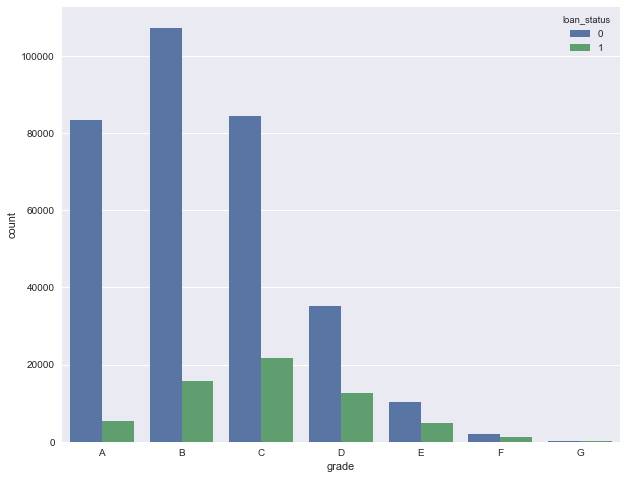

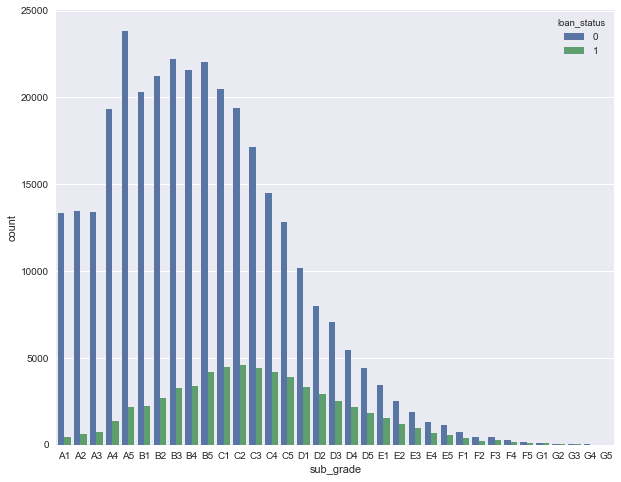

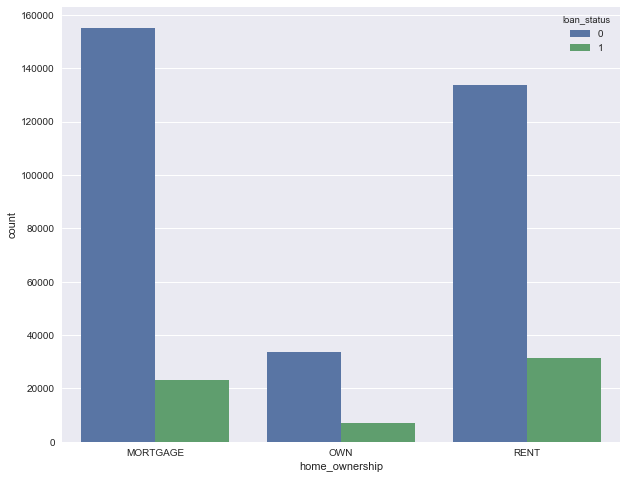

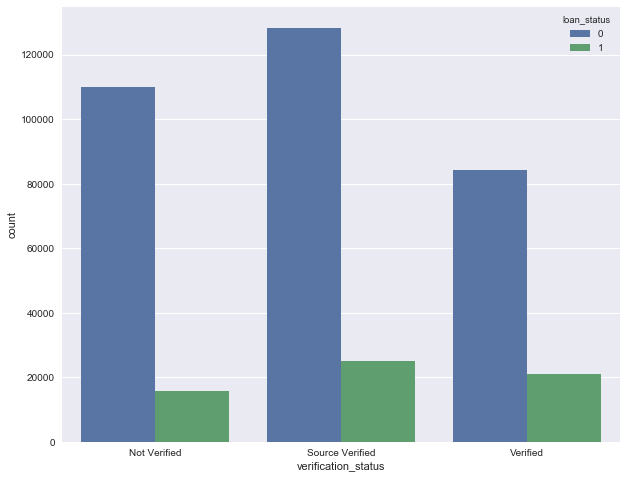

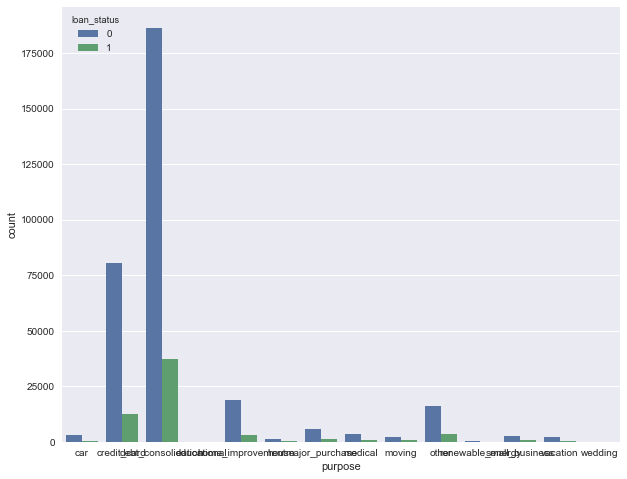

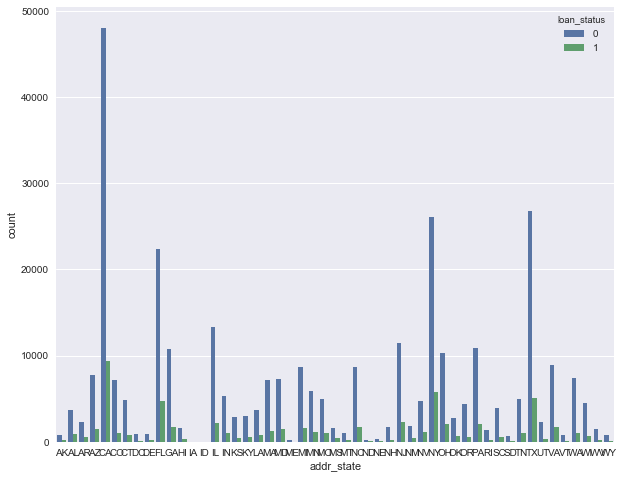

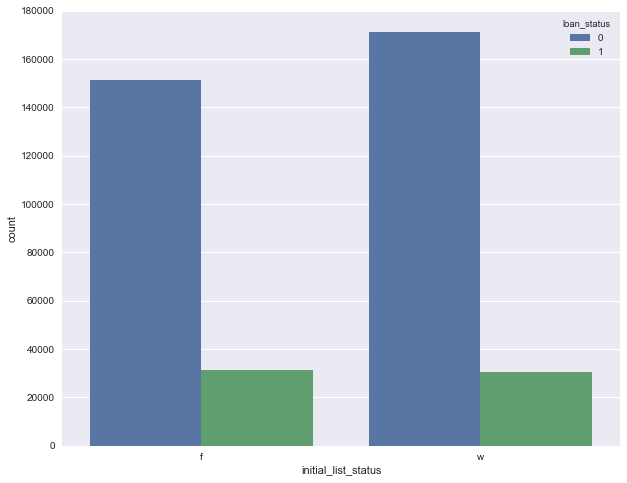

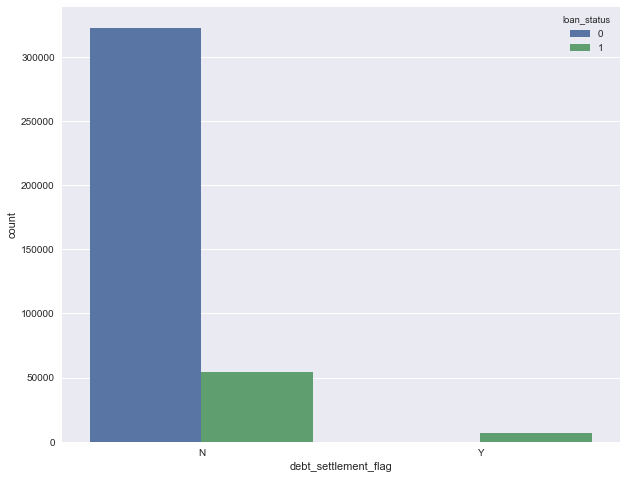

In [257]:
for x in cat_features_36:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.countplot(fulldata36[x].sort_values(),hue=fulldata36['loan_status'],ax=ax)
    plt.show()

#### Label encoding & one-hot encoding

Label encoding transfer catagorical features to numbers.

One-hot encoding transfter numbers to dummy variables to eliminate the ordinality in features.

Label encoding: Since grade and subgrade is ordinal, we should keep them in numbers.

In [258]:
def label_encoding(df,cat_features):
    print("Encode Variables")

    # import encoding tool  
    LE = preprocessing.LabelEncoder()

    LE_vars=[]
    LE_map=dict()
    for cat_var in cat_features:
        print ("Label Encoding %s" % (cat_var))
        LE_var=cat_var+'_le'
    #     Fit encoder and return encoded labels
        df[LE_var]=LE.fit_transform(df[cat_var].astype(str))
        LE_vars.append(LE_var)
    #     append encoded label to dict with its original contents
        LE_map[cat_var]=LE.classes_

    # Keep encoded cata features
    df.drop(cat_features, axis = 1, inplace =True)
    print ("Label-encoded feaures: %s" % (LE_vars))  

In [259]:
label_encoding(fulldata36, ['grade','sub_grade'])

Encode Variables
Label Encoding grade
Label Encoding sub_grade
Label-encoded feaures: ['grade_le', 'sub_grade_le']


One-hot encoding

In [260]:
fulldata36.shape

(384437, 72)

In [261]:
dummy_feature = ['home_ownership','verification_status','purpose','addr_state','initial_list_status','debt_settlement_flag']
fulldata36_dummy = pd.get_dummies(fulldata36[dummy_feature])

In [272]:
OHE_feature=list(fulldata36_dummy.columns.values)
OHE_feature

['home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Not Verified',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'addr_state_AK',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 'addr_state_CT',
 'addr_state_DC',
 'addr_state_DE',
 'addr_state_FL',
 'addr_state_GA',
 'addr_state_HI',
 'addr_state_IA',
 'addr_state_ID',
 'addr_state_IL',
 'addr_state_IN',
 'addr_state_KS',
 'addr_state_KY',
 'addr_state_LA',
 'addr_state_MA',
 'addr_state_MD',
 'addr_state_ME',
 'addr_state_MI',
 'addr_state_MN',
 'addr_state_MO',
 'addr_state_MS',
 'addr_state_MT',
 'addr

In [264]:
fulldata36_withDummy = pd.concat([fulldata36,fulldata36_dummy], axis=1 )

In [279]:
fulldata36_final = fulldata36_withDummy.drop(dummy_feature,axis = 1)

In [636]:
fulldata36_final.head()

,loan_amnt,int_rate,emp_length,annual_inc,issue_d,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,...,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,debt_settlement_flag_N,debt_settlement_flag_Y
0,10400,6.99,8,58000.0,44.83,1,14.92,0,352.23,2,...,0,0,0,0,0,0,0,1,1,0
1,9600,13.66,10,69000.0,44.83,0,25.81,0,313.67,0,...,0,0,0,0,0,0,1,0,1,0
2,7650,13.66,0,50000.0,44.83,1,34.81,0,195.00,1,...,0,0,0,0,0,0,1,0,1,0
3,23325,14.31,10,72000.0,44.83,1,27.03,1,241.67,0,...,0,0,1,0,0,0,1,0,1,0
4,17000,13.66,10,75000.0,44.83,0,23.63,0,214.23,0,...,0,0,0,0,0,0,1,0,1,0


In [281]:
fulldata36_final.shape

(384437, 141)

In [512]:
fulldata36_final['loan_status'].value_counts(normalize=True)

0    0.839552
1    0.160448
Name: loan_status, dtype: float64

In [650]:
testlist = [x for x in list(fulldata36_final.columns) if x not in ['zipcode_freq','emptitle_freq','2015_familyincome_median',  'addr_state_AK',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 'addr_state_CT',
 'addr_state_DC',
 'addr_state_DE',
 'addr_state_FL',
 'addr_state_GA',
 'addr_state_HI',
 'addr_state_IA',
 'addr_state_ID',
 'addr_state_IL',
 'addr_state_IN',
 'addr_state_KS',
 'addr_state_KY',
 'addr_state_LA',
 'addr_state_MA',
 'addr_state_MD',
 'addr_state_ME',
 'addr_state_MI',
 'addr_state_MN',
 'addr_state_MO',
 'addr_state_MS',
 'addr_state_MT',
 'addr_state_NC',
 'addr_state_ND',
 'addr_state_NE',
 'addr_state_NH',
 'addr_state_NJ',
 'addr_state_NM',
 'addr_state_NV',
 'addr_state_NY',
 'addr_state_OH',
 'addr_state_OK',
 'addr_state_OR',
 'addr_state_PA',
 'addr_state_RI',
 'addr_state_SC',
 'addr_state_SD',
 'addr_state_TN',
 'addr_state_TX',
 'addr_state_UT',
 'addr_state_VA',
 'addr_state_VT',
 'addr_state_WA',
 'addr_state_WI',
 'addr_state_WV',
 'addr_state_WY',
 'initial_list_status_f',
 'initial_list_status_w',
 'debt_settlement_flag_N',
 'debt_settlement_flag_Y','loan_status']]

## Model building

Split the data into 3 sets: train(0.56), test(0.2), valid(0.24)

In [393]:
fulldata36_final_train = fulldata36_final.iloc[:307549,:].drop('loan_status',axis = 1)
fulldata36_final_train_label = fulldata36_final.iloc[:307549,:]['loan_status']
fulldata36_final_test = fulldata36_final.iloc[307549:,:].drop('loan_status',axis = 1)
fulldata36_final_test_label = fulldata36_final.iloc[307549:,:]['loan_status']


In [394]:
X_train, X_valid, y_train, y_valid = train_test_split(fulldata36_final_train, fulldata36_final_train_label, 
                                                      test_size=0.3, random_state=2014, stratify = fulldata36_final_train_label)

In [395]:
X_test, y_test = fulldata36_final_test, fulldata36_final_test_label

In [396]:
X_train.shape, X_valid.shape, X_test.shape

((215284, 140), (92265, 140), (76888, 140))

##### Logistic Regression

In [656]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaledTrain = scaler.fit_transform(X_train)
X_scaledTest = scaler.fit_transform(X_test)
X_scaledValid = scaler.fit_transform(X_valid)

# Fit the data into model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 1234)
classifier.fit(X_scaledTrain, y_train)

# Predict using test set
y_pred = classifier.predict(X_scaledTest)
y_predvalid = classifier.predict(X_scaledValid)

from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)

acuscore = accuracy_score(y_test, y_pred)



In [655]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

0.9951690789225869

In [657]:
f1_score(y_test, y_pred, average='weighted')

0.9954982760666815

In [634]:
f1_score(y_test, y_pred, average='weighted')

(0.995525959837686, array([[65306,     1],
        [  343, 11238]]))

In [653]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     65307
          1       1.00      0.97      0.98     11581

avg / total       1.00      1.00      1.00     76888



In [635]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     65307
          1       1.00      0.97      0.98     11581

avg / total       1.00      1.00      1.00     76888



##### XGBOOST:
    
**Tree complexity: **
* max_depth
* min_child_weight
* gamma

**Schochastic gradient boosting: **
* subsample: 

%sample, model will randomly select data to train for each tree in case of noises and outliers. Typically 0.7-1. For useful data, 1 is also possible since every data is valuable to model. However, for data with a lot outliers and noise, smaller subsample is reasonable.
* colsample_bytree: 

%features, model will randomly select features to train for each tree. Typically 0.3 - 0.9. If data is sparse, then cbtree is smaller, if data is dense, then it should be larger.

**Boosting: **

*number of trees: how many trees or iteration we need. larger is better, however, existing a turning point that a model turns to overfitting.

*learning rate: smaller leads to better result but more time-consuming. Use a higher learning rate to start, focus on tuning other parameters. Then decreasing learning rate to optimize the result. Typically 0.01 to 0.1

In [322]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, # Learning rate
          "max_depth": 6,  # Complexity of tree, Typical 3-10, more deep, more easy to over-fitting
          "subsample": 0.7, 
          "colsample_bytree": 0.6,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          "gamma": 1, # min loss reduction required to make a further partition on leaf node
                       # penalize the complexity of tree
                       # the larger, the more conservative the model will be
                       # Typical 0 - 2
          "min_child_weight": 5} # min sum of weights of all observation required in a child, or
                                 # how many conditions we need to meet to keep split the next leaf(every leaf at least contains how many samples)
                                 #  which prevents the model over-fitting or learn outliers values
                                 # Typical 1-20
                                 # Note: in other model, if we have min_child_number instead of weight, it may need to be adjusted if we switch to train a larger dataset transfering from a small one, since the larger dataset may need more leafs to split to get a better performance


In [397]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test, y_test)

In [324]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500 # number of trees
# set-up model
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds= 20)

[0]	train-auc:0.957333	eval-auc:0.957454
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.990052	eval-auc:0.990214
[2]	train-auc:0.991758	eval-auc:0.992092
[3]	train-auc:0.993069	eval-auc:0.993258
[4]	train-auc:0.992096	eval-auc:0.992267
[5]	train-auc:0.992278	eval-auc:0.9924
[6]	train-auc:0.992677	eval-auc:0.992821
[7]	train-auc:0.992935	eval-auc:0.993148
[8]	train-auc:0.993869	eval-auc:0.994103
[9]	train-auc:0.994001	eval-auc:0.994136
[10]	train-auc:0.993733	eval-auc:0.993954
[11]	train-auc:0.994098	eval-auc:0.994318
[12]	train-auc:0.99409	eval-auc:0.994311
[13]	train-auc:0.994625	eval-auc:0.99482
[14]	train-auc:0.994182	eval-auc:0.994377
[15]	train-auc:0.995173	eval-auc:0.995457
[16]	train-auc:0.995877	eval-auc:0.996165
[17]	train-auc:0.99563	eval-auc:0.995916
[18]	train-auc:0.99575	eval-auc:0.996048
[19]	train-auc:0.995616	eval-auc:0.995917
[20]	train-auc:0.995507	eval-auc:0.

[191]	train-auc:0.99974	eval-auc:0.999605
[192]	train-auc:0.999744	eval-auc:0.999607
[193]	train-auc:0.999749	eval-auc:0.999616
[194]	train-auc:0.999749	eval-auc:0.999616
[195]	train-auc:0.999753	eval-auc:0.999619
[196]	train-auc:0.999756	eval-auc:0.999621
[197]	train-auc:0.999762	eval-auc:0.999625
[198]	train-auc:0.999764	eval-auc:0.999625
[199]	train-auc:0.999769	eval-auc:0.999629
[200]	train-auc:0.999769	eval-auc:0.999629
[201]	train-auc:0.999771	eval-auc:0.999633
[202]	train-auc:0.999775	eval-auc:0.999635
[203]	train-auc:0.999777	eval-auc:0.999637
[204]	train-auc:0.999777	eval-auc:0.999637
[205]	train-auc:0.999779	eval-auc:0.999646
[206]	train-auc:0.99978	eval-auc:0.999649
[207]	train-auc:0.999782	eval-auc:0.999648
[208]	train-auc:0.999782	eval-auc:0.99965
[209]	train-auc:0.999784	eval-auc:0.999651
[210]	train-auc:0.999784	eval-auc:0.999652
[211]	train-auc:0.999787	eval-auc:0.999654
[212]	train-auc:0.99979	eval-auc:0.99966
[213]	train-auc:0.999791	eval-auc:0.99966
[214]	train-auc:0

[383]	train-auc:0.999944	eval-auc:0.999804
[384]	train-auc:0.999944	eval-auc:0.999805
[385]	train-auc:0.999945	eval-auc:0.999806
[386]	train-auc:0.999945	eval-auc:0.999806
[387]	train-auc:0.999945	eval-auc:0.999806
[388]	train-auc:0.999946	eval-auc:0.999807
[389]	train-auc:0.999946	eval-auc:0.999808
[390]	train-auc:0.999946	eval-auc:0.999808
[391]	train-auc:0.999947	eval-auc:0.999809
[392]	train-auc:0.999947	eval-auc:0.999809
[393]	train-auc:0.999948	eval-auc:0.99981
[394]	train-auc:0.999949	eval-auc:0.999808
[395]	train-auc:0.999949	eval-auc:0.999808
[396]	train-auc:0.999949	eval-auc:0.999808
[397]	train-auc:0.999949	eval-auc:0.999809
[398]	train-auc:0.999949	eval-auc:0.999808
[399]	train-auc:0.99995	eval-auc:0.999809
[400]	train-auc:0.99995	eval-auc:0.999811
[401]	train-auc:0.99995	eval-auc:0.999812
[402]	train-auc:0.99995	eval-auc:0.999812
[403]	train-auc:0.999951	eval-auc:0.999812
[404]	train-auc:0.999951	eval-auc:0.999813
[405]	train-auc:0.999952	eval-auc:0.999813
[406]	train-auc:

##### Feature Importance

In [445]:
importance=gbm.get_fscore()

In [449]:
list(importance.items())

[('last_pymnt_amnt', 1497),
 ('last_credit_pull_d', 370),
 ('issue_d', 548),
 ('debt_settlement_flag_N', 113),
 ('total_pymnt', 2093),
 ('loan_amnt', 1219),
 ('total_rec_late_fee', 296),
 ('emp_length', 83),
 ('recoveries', 141),
 ('last_pymnt_d', 796),
 ('total_rec_int', 1322),
 ('annual_inc', 136),
 ('revol_bal', 142),
 ('verification_status_Not Verified', 21),
 ('int_rate', 351),
 ('sub_grade_le', 233),
 ('debt_settlement_flag_Y', 40),
 ('grade_le', 80),
 ('revol_util', 128),
 ('avg_cur_bal', 89),
 ('mo_sin_old_rev_tl_op', 103),
 ('mo_sin_old_il_acct', 84),
 ('bc_util', 100),
 ('dti', 167),
 ('total_acc', 52),
 ('num_tl_op_past_12m', 16),
 ('acc_open_past_24mths', 55),
 ('emptitle_freq', 104),
 ('total_bc_limit', 90),
 ('num_bc_sats', 38),
 ('num_il_tl', 41),
 ('mort_acc', 20),
 ('num_bc_tl', 63),
 ('num_actv_rev_tl', 58),
 ('purpose_debt_consolidation', 15),
 ('num_op_rev_tl', 28),
 ('purpose_home_improvement', 1),
 ('purpose_other', 4),
 ('num_actv_bc_tl', 31),
 ('tot_cur_bal', 82

In [460]:
df_importance = pd.DataFrame(list(importance.items()), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()
df_importance.sort_values(['fscore'], ascending=False, inplace=True)

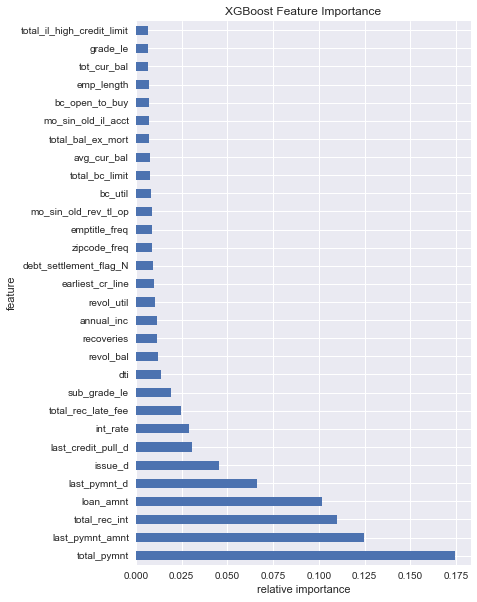

In [478]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:30].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [623]:
feature_importance = list(df_importance[:50]['feature'])

In [631]:
best_xgb_iteration=503
clf_train = xgb.XGBClassifier(learning_rate = 0.05
                  , n_estimators =best_xgb_iteration
                  , max_depth = 6
                  , min_child_weight = 5
                  , subsample = 0.7
                  , colsample_bytree = 0.6 
                  , gamma = 1
                  , seed = 1234
                  , silent = 1
                  )

clf_train.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=5, missing=None, n_estimators=503,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234, silent=1,
       subsample=0.7)

In [627]:
y_pred_xg= clf_train.predict(X_test)

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [628]:
confusion_matrix(y_test, y_pred_xg)

array([[65306,     1],
       [  261, 11320]])

In [629]:
acuscore = accuracy_score(y_test, y_pred_xg)

In [630]:
acuscore

0.9965924461554468

#### LogisticRegression Model

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaledTrain = scaler.fit_transform(X_train)
X_scaledTest = scaler.fit_transform(X_test)
X_scaledValid = scaler.fit_transform(X_valid)

# Fit the data into model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 1234)
classifier.fit(X_scaledTrain, y_train)

# Predict using test set
y_pred = classifier.predict(X_scaledTest)
y_predvalid = classifier.predict(X_scaledValid)

from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
cmvalid = confusion_matrix(y_valid, y_predvalid)

acuscore = accuracy_score(y_test, y_pred)
acuscorevalide = accuracy_score(y_valid, y_predvalid)

In [575]:
cm

array([[65306,     1],
       [  343, 11238]])

In [545]:
cmvalid

array([[77227,     8],
       [  434, 14596]])

In [546]:
cmvalid

array([[77227,     8],
       [  434, 14596]])

In [414]:
acuscore,acuscorevalide

(0.995525959837686, 0.996748496179483)

In [585]:
acuscore,acuscorevalide

(0.9956039954219124, 0.9968135262558934)

In [515]:
from sklearn.metrics import classification_report

In [517]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     65307
          1       1.00      0.97      0.98     11581

avg / total       1.00      1.00      1.00     76888

